# Estonian Primary School Mathematics Exam Results
Authors: SOOP, Oskar; PAE, Markus Rene; BAO, Han

## Project Overview
This notebook generates and analyzes synthetic data for Estonian primary school mathematics exam results. We will simulate a realistic dataset based on actual exam statistics from 2016-2023. There was no mandatory exam in 2020 due to Covid-19.

## Exam Details
- Maximum possible score: 50 points
- Minimum passing score: 25 points (consistent across 2016-2023)

## Causal Model
We'll simulate how various factors influence exam performance using a directed acyclic graph (DAG) that includes:
- Language (Domestic background)
- County of residence
- Gender
- Average grade
- Year-specific factors
- Exam difficulty

Our goal is to create realistic synthetic data that a subsequent team can use to build and test statistical models.

## Getting Started
First, we'll import the necessary libraries for data manipulation and Bayesian modeling.

In [3]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

# The Data

This section loads and processes the historical math exam data from CSV files. We'll use this data to inform our synthetic data generation process, ensuring our simulated results match the statistical properties of real exam outcomes.

The data includes:
- Year of the exam
- Number of students (N)
- Mean score
- Standard deviation
- Number of students who got minimum (0) and maximum (50) scores

We'll extract key statistics to use as priors in our generative model.

In [4]:
# load math‐exam summary CSVs 
files_math = sorted(glob.glob("math_exam_csvs/math_exam_*.csv"))
dfs_math = []
for fn in files_math:
    dfm = pd.read_csv(
        fn,
        sep=";",       # math CSVs are semicolon‐delimited
        decimal=",",   # comma for decimals
        engine="python",
        skiprows=0     # first row is the header in math files
    )
    # rename to our working names
    dfm = dfm.rename(columns={
        "Aasta":                     "year",
        "Sooritajaid":               "N",
        "Keskmine":                  "mean_score",
        "St hälve":                  "sd_score",
        "Min punktide saajad":       "min_score_count",
        "Max punktide saajad":       "max_score_count"
    })
    dfs_math.append(dfm[["year","N","mean_score","sd_score","min_score_count","max_score_count"]])

df_math = pd.concat(dfs_math, ignore_index=True)

Below is the summary table of math exam statistics across years. This shows the number of students, mean scores, standard deviations, and counts of minimum and maximum scores for each exam year

In [3]:
df_math.head(100)

,year,N,mean_score,sd_score,min_score_count,max_score_count
0,2016,1826,34.2,10.9,2,52
1,2017,1472,36.8,11.5,7,39
2,2018,1848,33.5,13.2,23,91
3,2019,1886,36.5,10.8,5,64
4,2021,1794,28.0,13.6,11,31
5,2022,1820,29.8,14.2,2,64
6,2023,1850,32.3,13.6,17,59


The following cell helps us to set good priors for our model by calculating summary statistics from the math exam data. We extract the years, student counts, weighted mean scores, average standard deviations, and min/max counts.

In [5]:
#we derive prior information from the loaded df_math  
YEARS_math          = sorted(df_math["year"].unique())
student_counts = {                          # Number of graduates from https://andmed.stat.ee/et/stat/sotsiaalelu__haridus__uldharidus/HT17/table/tableViewLayout2
                    2016: 11611,            # Should be a good approximation of students who took the exam
                    2017: 11539,
                    2018: 11606,
                    2019: 11884,
                    2021: 13027,
                    2022: 13626,
                    2023: 14376
                }

# Calculate weighted mean using N as weights
mu_math             = (df_math["mean_score"] * df_math["N"]).sum() / df_math["N"].sum()
sd_math             = (df_math["sd_score"] * df_math["N"]).sum() / df_math["N"].sum()
min_math            = df_math["min_score_count"].min()
max_math            = df_math["max_score_count"].max() 

print("MATH YEARS:", YEARS_math)
print("MATH counts:", student_counts)
print("MATH mean μ, avg σ:", mu_math, sd_math)
print("MATH min/max counts:", min_math, max_math)


MATH YEARS: [2016, 2017, 2018, 2019, 2021, 2022, 2023]
MATH counts: {2016: 11611, 2017: 11539, 2018: 11606, 2019: 11884, 2021: 13027, 2022: 13626, 2023: 14376}
MATH mean μ, avg σ: 32.937644046094746 12.56371638924456
MATH min/max counts: 2 91


Below is our Directed Acyclic Graph (DAG) representing the causal relationships in our model. 

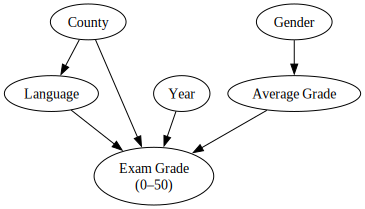

In [5]:
from graphviz import Digraph

dot = Digraph()

# Nodes
dot.node('Language', 'Language')
dot.node('County', 'County')
dot.node('Gender', 'Gender')
dot.node('Year', 'Year')
dot.node('Average Grade', 'Average Grade')
dot.node('Exam', 'Exam Grade\n(0–50)')

# Edges
dot.edge('County','Language') 
dot.edge('County', 'Exam')   
dot.edge('Language', 'Exam')   
dot.edge('Year', 'Exam')  
dot.edge('Gender', 'Average Grade')  
dot.edge('Average Grade', 'Exam')

# Display the graph
dot.render('dag', format='png', cleanup=False)
dot

# Parameters for the Generative Model
 
Before implementing our generative model, we need to establish appropriate parameters for each variable in our DAG. These parameters define the relationships between variables in our model:
 
- **County**: Based on population distribution across Estonian counties
- **Language (Domestic Background)**: Determined by Russian-speaking percentages in each county
- **Gender**: Equal probability for male and female students
- **Average Grade**: Affected by gender
- **Year**: Exam DifficultyVaries by year
- **Exam Grade**: Final score (0-50) determined by all upstream factors
 
These parameters will guide our data generation process and ensure the synthetic data maintains realistic relationships between variables.

In [6]:
# Define county data with populations and Russian-speaking percentages
COUNTY_DATA = {
    "Harjumaa":     {"population": 630000, "russian_pct": 0.259, "honesty_coef": 1.2, "county_coef": 0.472},
    "Hiiumaa":      {"population": 9000,   "russian_pct": 0.005, "honesty_coef": 1.2, "county_coef": -0.183},
    "Ida-Virumaa":  {"population": 130000, "russian_pct": 0.696, "honesty_coef": 3.0, "county_coef": 0.756},
    "Järvamaa":     {"population": 30000,  "russian_pct": 0.021, "honesty_coef": 1.1, "county_coef": -0.429},
    "Jõgevamaa":    {"population": 28000,  "russian_pct": 0.063, "honesty_coef": 1.3, "county_coef": 0.891},
    "Läänemaa":     {"population": 20000,  "russian_pct": 0.070, "honesty_coef": 1.2, "county_coef": 0.327},
    "Lääne-Virumaa":{"population": 60000,  "russian_pct": 0.083, "honesty_coef": 1.4, "county_coef": -0.642},
    "Põlvamaa":     {"population": 24000,  "russian_pct": 0.032, "honesty_coef": 1.1, "county_coef": 0.115},
    "Pärnumaa":     {"population": 85000,  "russian_pct": 0.060, "honesty_coef": 1.5, "county_coef": -0.938},
    "Raplamaa":     {"population": 34000,  "russian_pct": 0.030, "honesty_coef": 1.1, "county_coef": 0.274},
    "Saaremaa":     {"population": 33000,  "russian_pct": 0.006, "honesty_coef": 1.2, "county_coef": -0.503},
    "Tartumaa":     {"population": 160000, "russian_pct": 0.091, "honesty_coef": 1.4, "county_coef": 0.662},
    "Valgamaa":     {"population": 27000,  "russian_pct": 0.116, "honesty_coef": 1.3, "county_coef": -0.791},
    "Viljandimaa":  {"population": 45000,  "russian_pct": 0.023, "honesty_coef": 1.2, "county_coef": 0.038},
    "Võrumaa":      {"population": 35000,  "russian_pct": 0.032, "honesty_coef": 1.3, "county_coef": -0.157},
}

# Prior information about math scores
mu_math = 33.01  # Mean score from true data
sd_math = 12.54  # Standard deviation from true data

# Gender prior (equal distribution between male and female)
gender_probs = [0.5, 0.5]  # 0: Male, 1: Female

# Simulation parameters
YEARS = [2016, 2017, 2018, 2019, 2021, 2022, 2023]  # Available years
student_counts = {
    2016: 11611,
    2017: 11539,
    2018: 11606,
    2019: 11884,
    2021: 13027,
    2022: 13626,
    2023: 14376
}

# Effect dictionaries
effects = {
    "domestic_background_tse": {'Estonian': -0.1, 'Russian': 0.2},
    "gender_tse": {'Male': 0.2, 'Female': -0.1},
    "gender_grade": {'Male': -0.2, 'Female': 0.2},
    "year": {
        "grade": {2016: 0.0, 2017: 0.1, 2018: -0.1, 2019: 0.05, 2021: 0.15, 2022: 0.1, 2023: 0.05},
        "difficulty": {2016: 0.5, 2017: 1, 2018: -0.4, 2019: 0.9, 2021: -1.4, 2022: -1.2, 2023: 0.4}
    }
}

# Extract lists for model use
COUNTIES = list(COUNTY_DATA.keys())
populations = np.array([COUNTY_DATA[county]["population"] for county in COUNTIES])
rus_probs = np.array([COUNTY_DATA[county]["russian_pct"] for county in COUNTIES])

# Normalize populations to get probabilities
county_probs = populations / populations.sum()

Let's save the results.

# Data generation model

In [239]:
from scipy.stats import truncnorm

def generate_data_for_year(year, normal_model_weight=0.0):
    """
    Generate exam data for a specific year
    
    Parameters:
    -----------
    year : int
        The year to generate data for
    normal_model_weight : float, default 0.7
        The weight (between 0 and 1) to assign to the normal model.
        The remaining weight (1-normal_model_weight) will be assigned to the linear model.
    """
    n_students = student_counts[year]
    
    # Randomly assign counties based on population distribution
    counties_idx = np.random.choice(len(COUNTIES), size=n_students, p=county_probs)
    counties = np.array([COUNTIES[idx] for idx in counties_idx])
    
    # Randomly assign domestic background based on Russian-speaking population in the counties
    domestic_background_numeric = np.array([np.random.binomial(1, rus_probs[counties_idx[i]]) for i in range(n_students)])
    domestic_background = np.array(['Estonian' if db == 0 else 'Russian' for db in domestic_background_numeric])
    
    # Randomly assign genders
    genders_numeric = np.random.choice([0, 1], size=n_students, p=gender_probs)
    genders = np.array(['Male' if gen == 0 else 'Female' for gen in genders_numeric])
    
    
    
    # Randomly assign Avg grade from truncated normal distribution conditioned on gender
    avg_grades = np.zeros(n_students)

    ## Truncated normal distribution parameters
    a_trunc=1
    b_trunc=5
    m_loc=4
    m_scale=1
    a_m, b_m = (a_trunc - m_loc) / m_scale, (b_trunc - m_loc) / m_scale
    f_loc=4.2
    f_scale=0.8
    a_f, b_f = (a_trunc - f_loc) / f_scale, (b_trunc - f_loc) / f_scale

    model_selector = np.random.random(n_students) < normal_model_weight

    for i, gender in enumerate(genders):
        if np.random.random() < normal_model_weight:
            if gender == 'Male':  # For Male
                avg_grades[i] = truncnorm.rvs(a_m, b_m, loc=4.0, scale=1.0)  # Truncated normal with mean=4.0 and std=1.0
            else:
                avg_grades[i] = truncnorm.rvs(a_f, b_f, loc=4.2, scale=0.8) # Truncated normal with mean=4.2 and std=0.8
        else:
            avg_grades[i] = 5*np.cbrt(np.random.random())
    
    # This year's test's difficulty (non-random)
    difficulty = effects["year"].get("difficulty", {}).get(year, 0)
    
    # Exam grades effect from this year's test difficulty, language and county background
    total_effect = (
        # np.array([effects["gender_grade"][g] for g in genders]) + 
        -5 * difficulty +
        3*np.array([effects["domestic_background_tse"][db] for db in domestic_background]) +
        3*np.array([COUNTY_DATA[county]["county_coef"] for county in counties])
    )

    effect_multiplier = 23 * (1 / (1 + np.exp(-total_effect / 5))-0.5)  


    
    
    exam_grades = np.random.normal(avg_grades*10-1+(avg_grades*(5-avg_grades)/6.25+0.1)*effect_multiplier, 3*avg_grades**2*(1-avg_grades/5)**2+0.1 )
  
    
    # Clip and round all scores
    exam_grades = np.round(np.clip(exam_grades, 0, 50))
    
    # BONUS: Exam scores are rounded up if it is close to the next grade. 
    base_rounding_prob = 0.05
    rounding_probs = np.ones(n_students) * base_rounding_prob
    for i, county in enumerate(counties):
        rounding_probs[i] *= COUNTY_DATA[county]["honesty_coef"]
    
    rounding_mask = (
    (exam_grades >= 23.5) & (exam_grades < 24.5) |
    (exam_grades >= 33.5) & (exam_grades < 34.5) |
    (exam_grades >= 43.5) & (exam_grades < 44.5)
    )
    rounding = np.random.binomial(1, rounding_probs * rounding_mask)
    exam_grades = exam_grades + rounding
    
    # Ensure all scores are integers
    exam_grades = exam_grades.astype(int)
    
    data = pd.DataFrame({
        'year': year,
        'county': counties,
        'domestic_background': domestic_background,
        'gender': genders,
        'avg_grade': avg_grades,
        'exam_score': exam_grades,
        'difficulty': difficulty,
        'total_effect': total_effect,
        'effect_multiplier': effect_multiplier
    })
    
    return data

# Generate data for all years and combine them
all_data = pd.concat([generate_data_for_year(year) for year in YEARS], ignore_index=True)
print(all_data.head(20))


    year       county domestic_background  gender  avg_grade  exam_score  \
0   2016     Tartumaa            Estonian    Male   1.559284           7   
1   2016     Harjumaa            Estonian  Female   4.675622          45   
2   2016     Harjumaa            Estonian  Female   4.524282          43   
3   2016     Harjumaa            Estonian    Male   4.954787          48   
4   2016  Ida-Virumaa             Russian    Male   2.717434          23   
5   2016     Harjumaa            Estonian  Female   4.591868          44   
6   2016     Harjumaa            Estonian    Male   4.272041          42   
7   2016     Harjumaa            Estonian    Male   4.848564          47   
8   2016     Tartumaa            Estonian  Female   4.804257          47   
9   2016     Pärnumaa            Estonian    Male   2.922998          13   
10  2016     Harjumaa            Estonian    Male   4.578943          45   
11  2016     Valgamaa             Russian    Male   4.472586          41   
12  2016    

# Save data

In [8]:
# Save the DataFrame to a CSV file
output_file = "math_exam_scores.csv"
df_selection = all_data[["year", "county","domestic_background","gender","exam_score"]]
df_selection.to_csv(output_file, index=False, sep=";")

# Sample visualisation

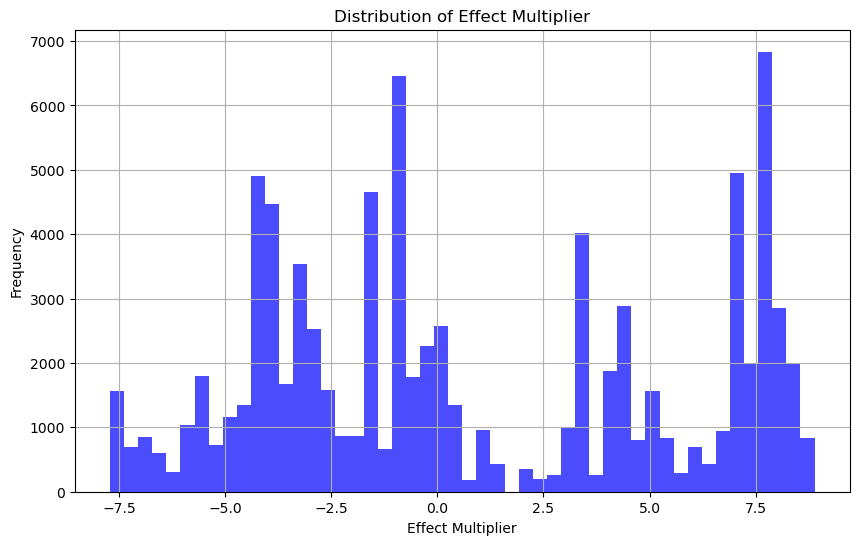

In [240]:
# Plot effect multiplier
plt.figure(figsize=(10, 6))
plt.hist(all_data["effect_multiplier"], bins=50, alpha=0.7, color='blue')
plt.xlabel("Effect Multiplier")
plt.ylabel("Frequency")
plt.title("Distribution of Effect Multiplier")
plt.grid()
plt.show()

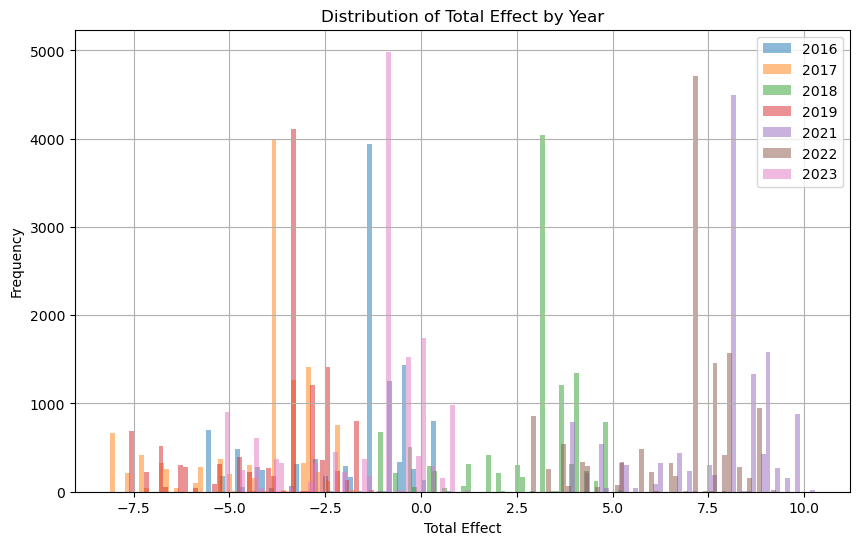

In [234]:
# Plot total effect by year
plt.figure(figsize=(10, 6))
for year in YEARS:
    plt.hist(all_data[all_data["year"] == year]["total_effect"], bins=50, alpha=0.5, label=str(year))
plt.xlabel("Total Effect")
plt.ylabel("Frequency")
plt.title("Distribution of Total Effect by Year")
plt.legend()
plt.grid()
plt.show()

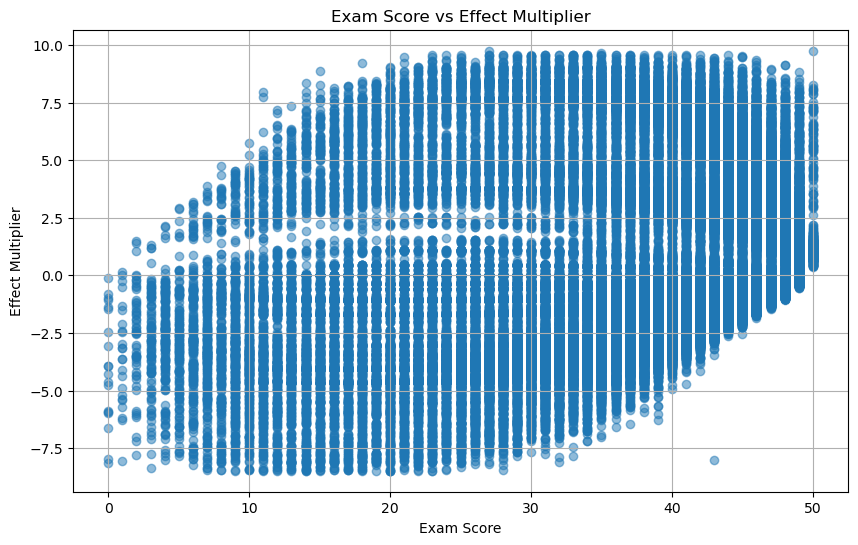

In [241]:
# Plot exam scores vs effect multiplier
plt.figure(figsize=(10, 6))
plt.scatter(all_data["exam_score"], (all_data["avg_grade"]*(5-all_data["avg_grade"])/6.25+0.1)*all_data["effect_multiplier"], alpha=0.5)
plt.xlabel("Exam Score")
plt.ylabel("Effect Multiplier")
plt.title("Exam Score vs Effect Multiplier")
plt.grid()
plt.show()

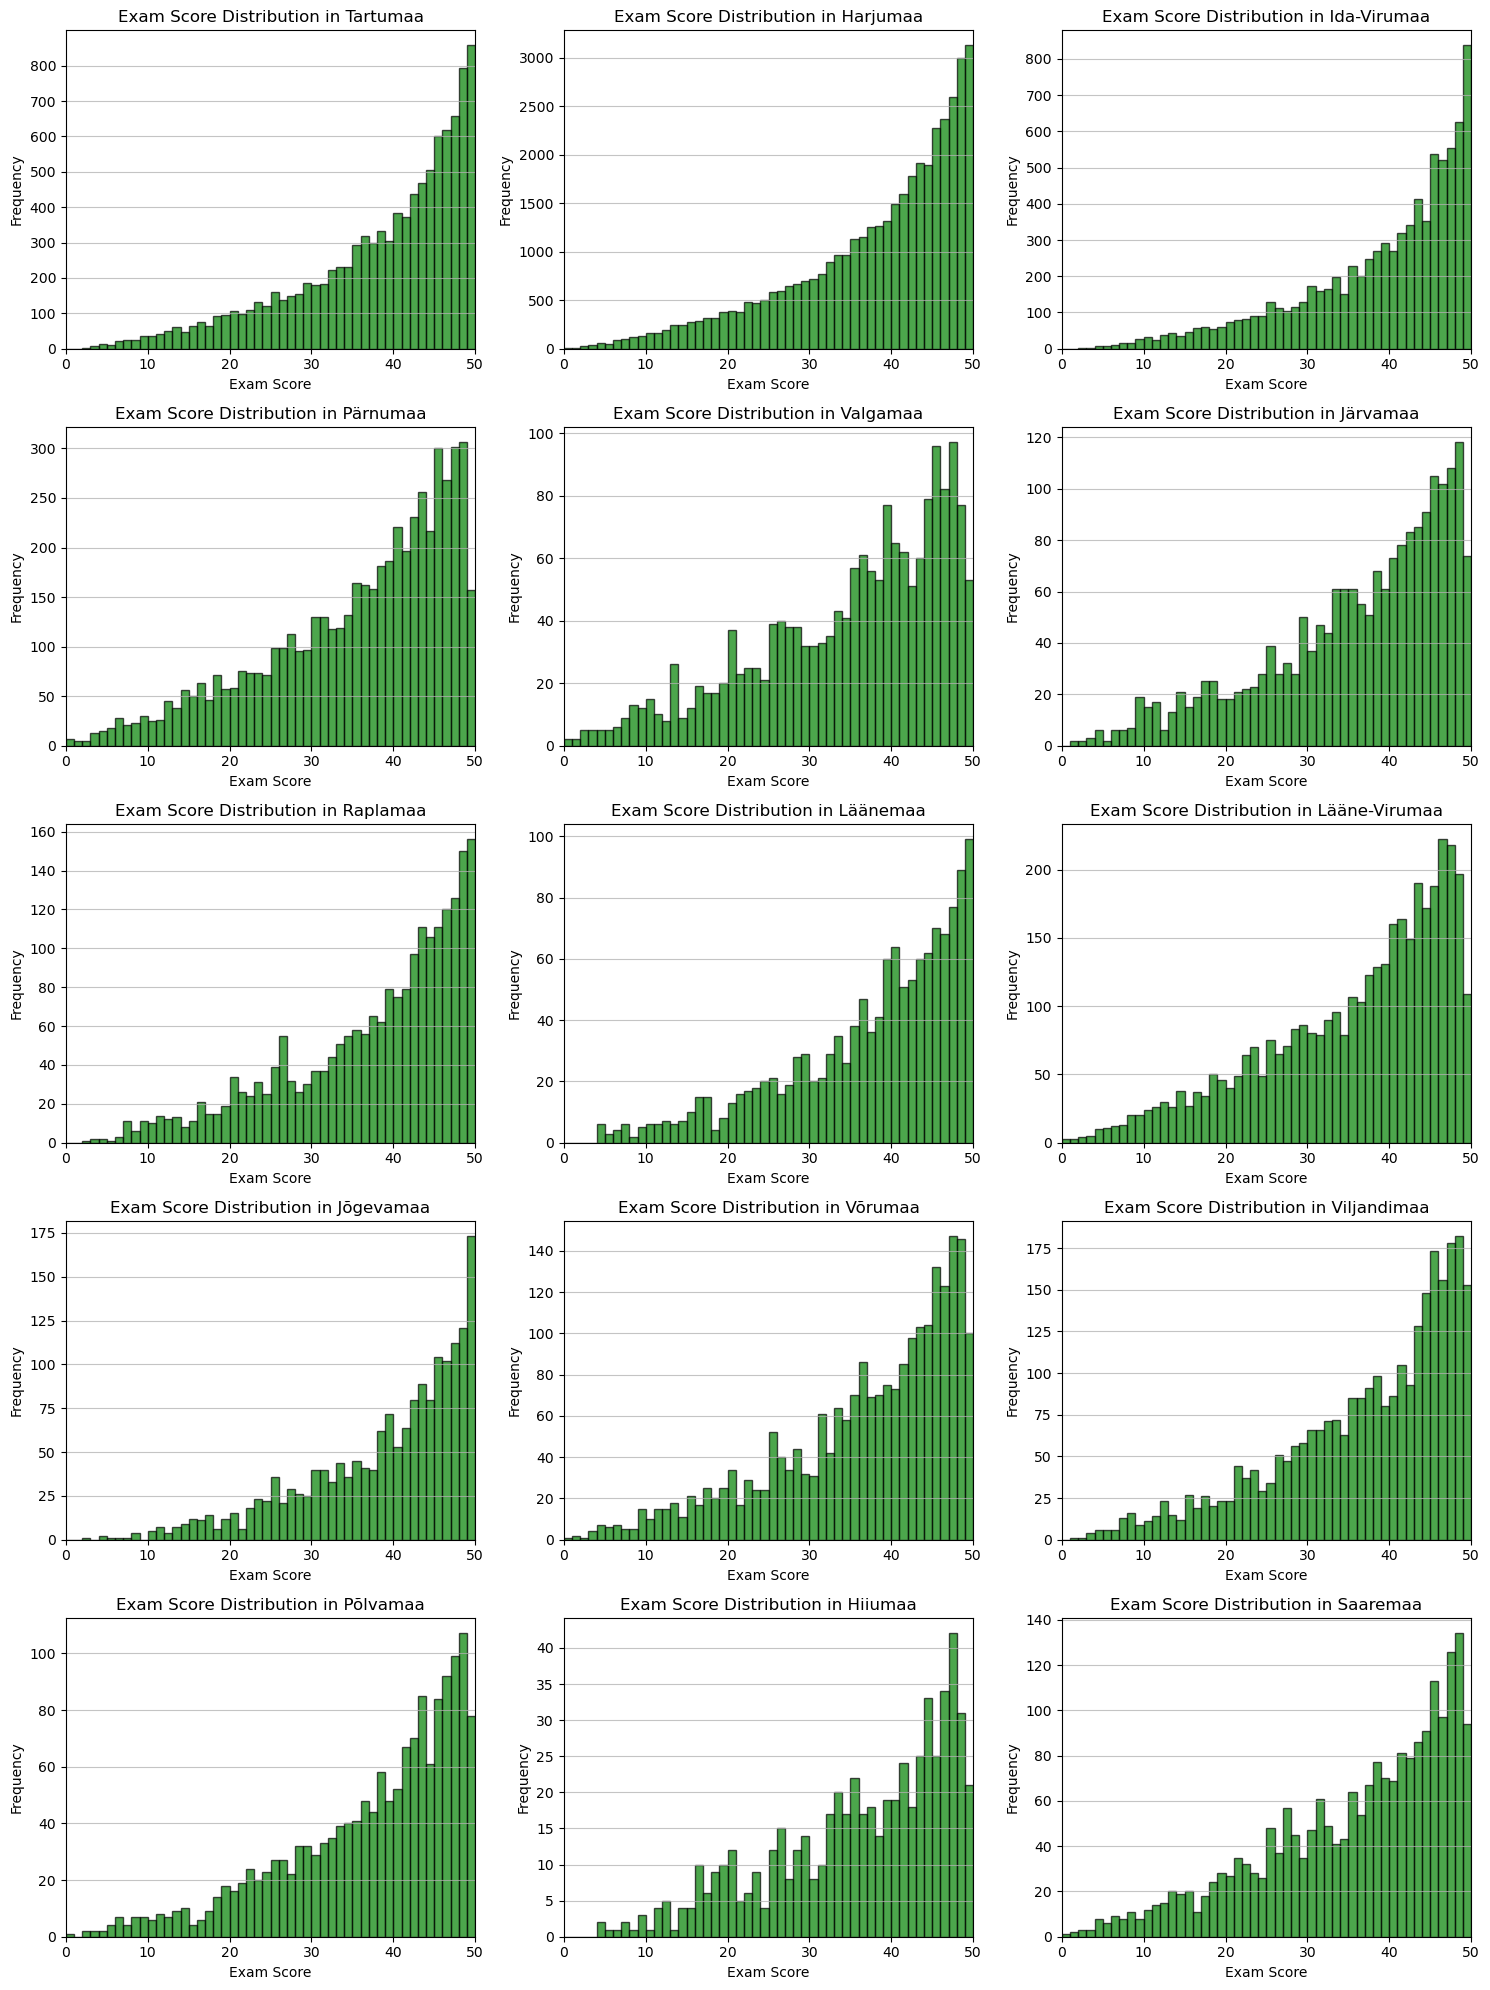

In [242]:
# Analyze exam scores distribution for all counties
# Get unique counties
counties = all_data['county'].unique()

# Create a 5x3 subplot grid
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()

# Plot histogram for each county
for i, county in enumerate(counties):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        county_data = all_data[all_data['county'] == county]
        
        axes[i].hist(county_data['exam_score'], bins=range(51), color='green', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Exam Score Distribution in {county}')
        axes[i].set_xlabel('Exam Score')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 50)
        axes[i].grid(axis='y', alpha=0.75)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

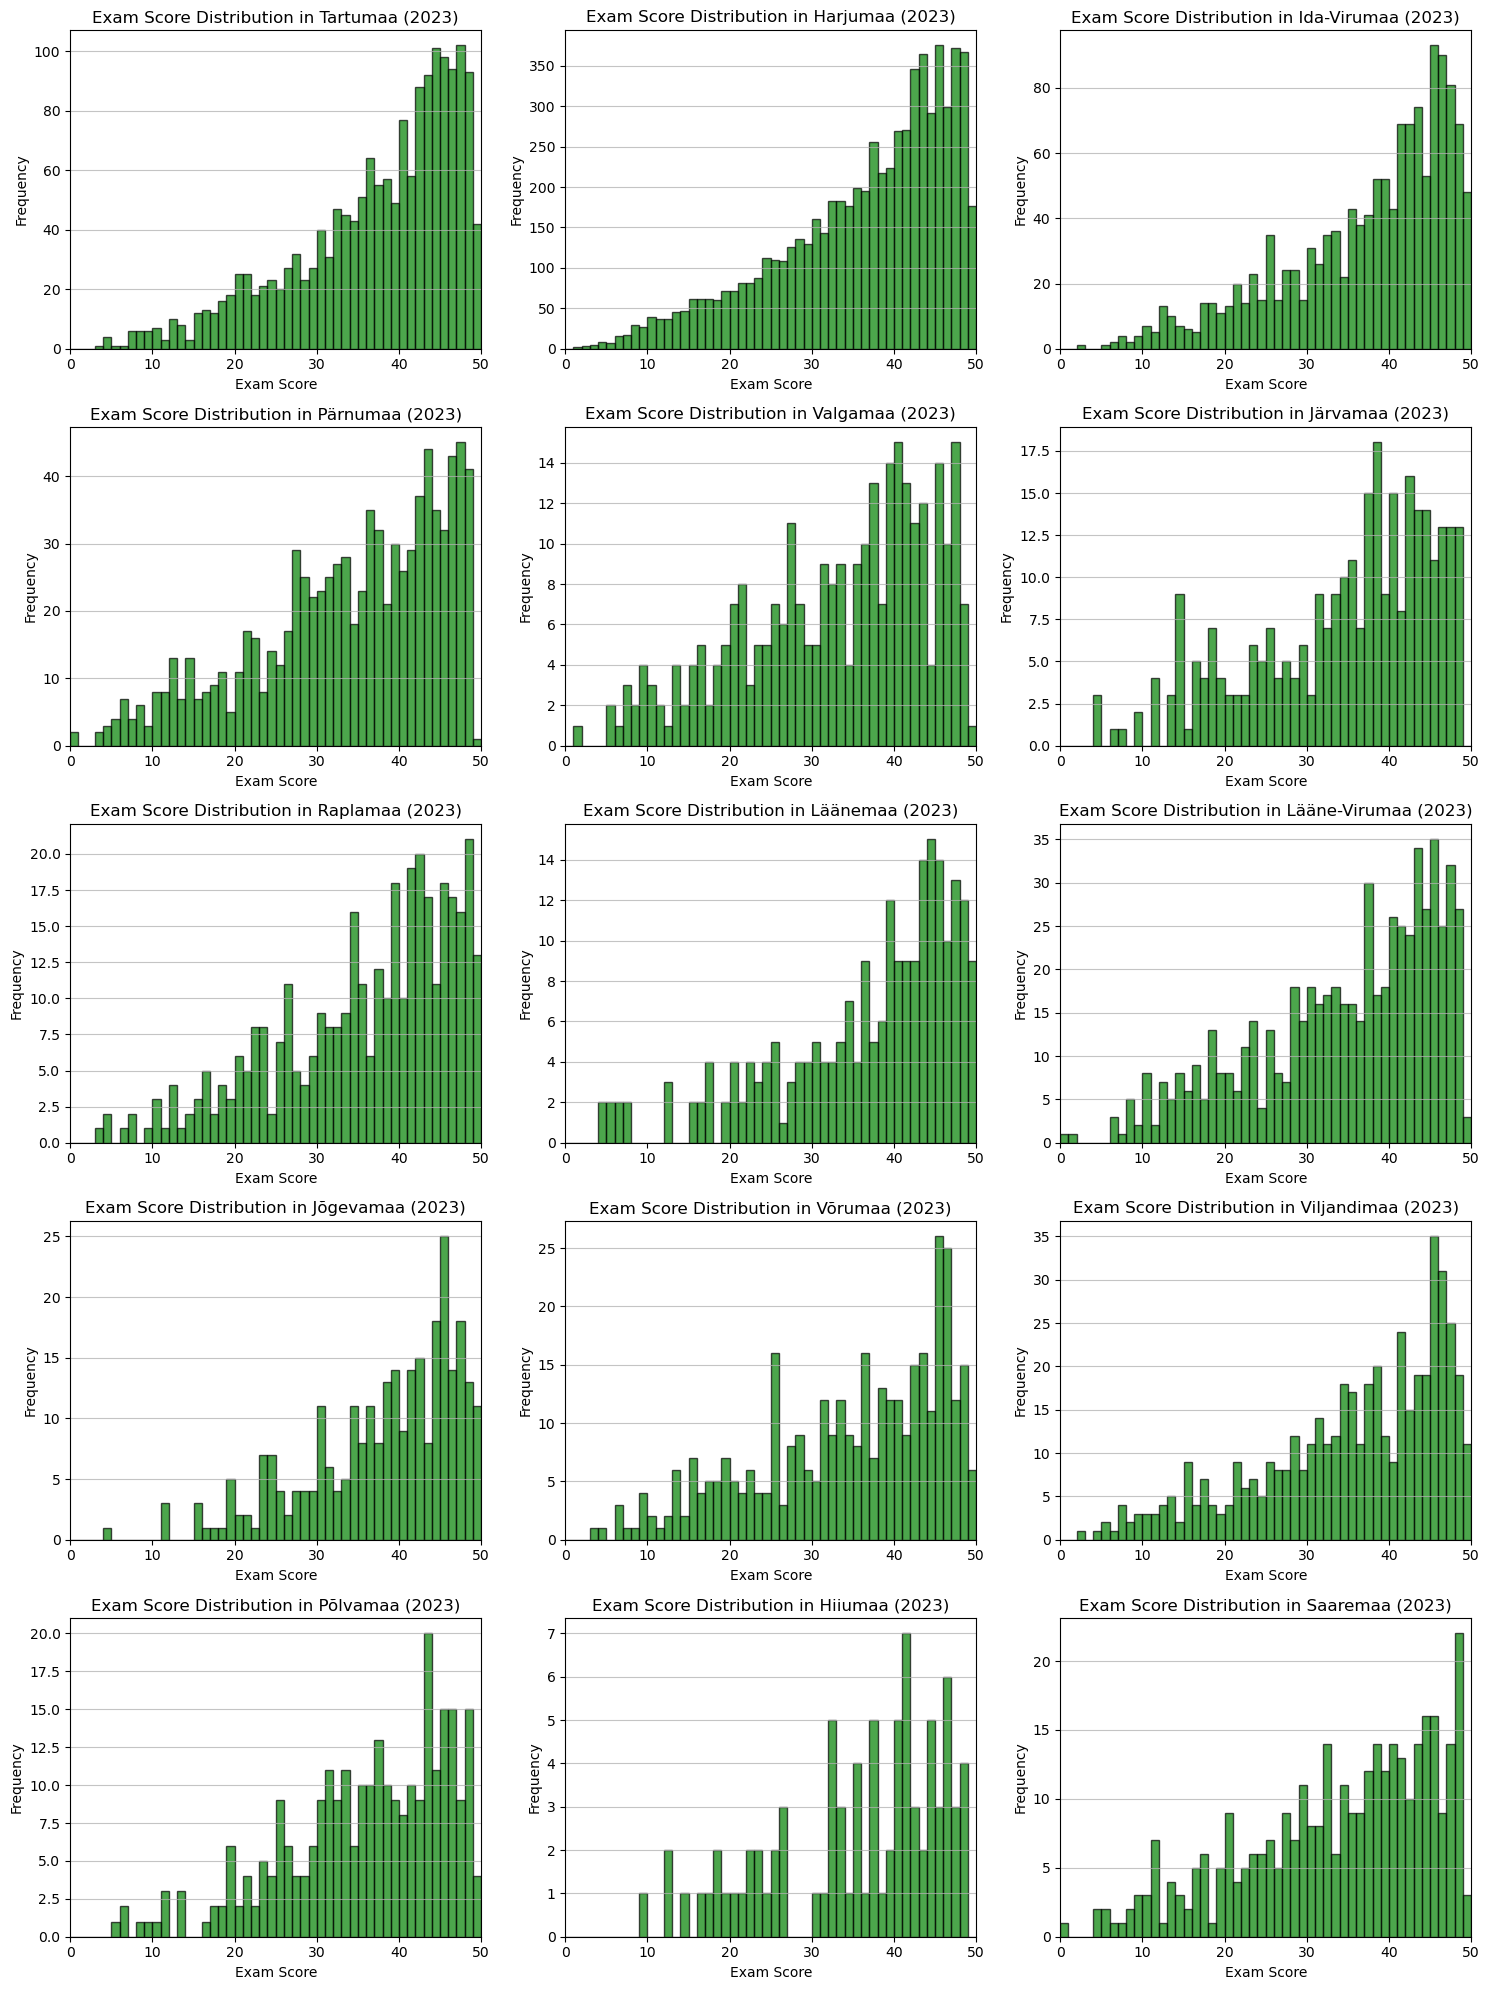

In [243]:
# Analyze exam scores distribution for all counties in year 2023
# Get unique counties
counties = all_data['county'].unique()
# Create a 5x3 subplot grid
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.flatten()
# Plot histogram for each county
for i, county in enumerate(counties):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        county_data = all_data[(all_data['county'] == county) & (all_data['year'] == 2023)]
        
        axes[i].hist(county_data['exam_score'], bins=range(51), color='green', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Exam Score Distribution in {county} (2023)')
        axes[i].set_xlabel('Exam Score')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 50)
        axes[i].grid(axis='y', alpha=0.75)
# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

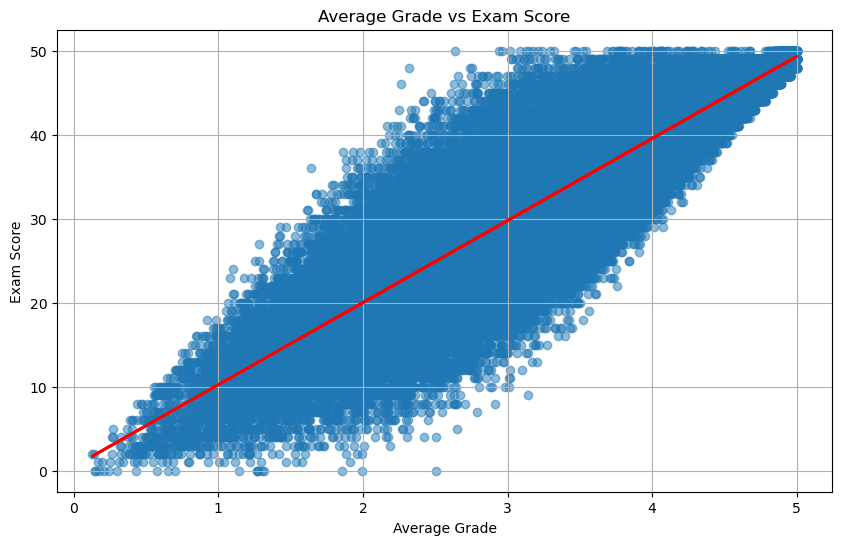

In [244]:
# Fit a linear regression model average grade vs exam score
import statsmodels.api as sm
X = all_data[['avg_grade']]
y = all_data['exam_score']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
plt.figure(figsize=(10, 6))
plt.scatter(all_data['avg_grade'], all_data['exam_score'], alpha=0.5)
plt.plot(all_data['avg_grade'], predictions, color='red', linewidth=2)
plt.title('Average Grade vs Exam Score')
plt.xlabel('Average Grade')
plt.ylabel('Exam Score')
plt.grid()
plt.show()


<Figure size 1000x600 with 0 Axes>

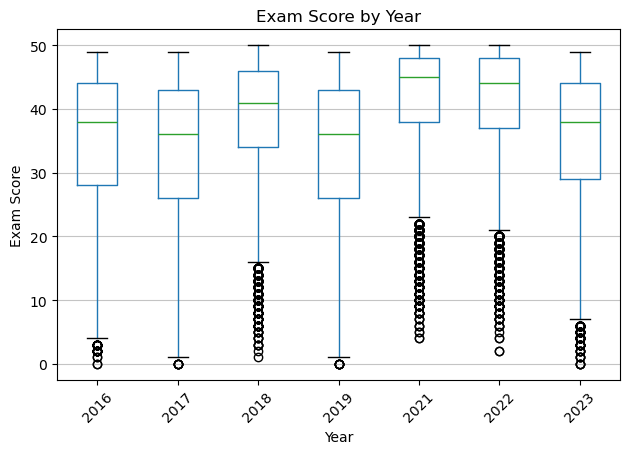

In [245]:
# Plot yearly exam score as box plot

plt.figure(figsize=(10, 6))
all_data.boxplot(column='exam_score', by='year', grid=False)
plt.title('Exam Score by Year')
plt.suptitle('')
plt.xlabel('Year')
plt.ylabel('Exam Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

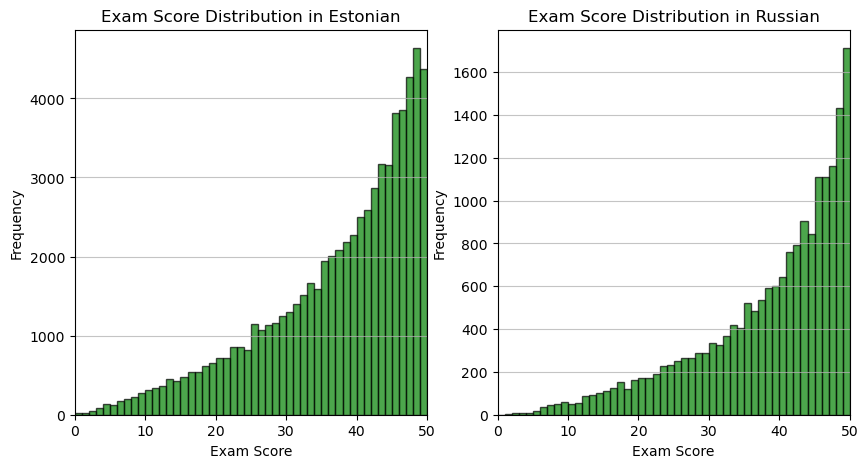

In [246]:
# Analyze exam scores distribution for all languages
# Get unique languages
languages = all_data['domestic_background'].unique()
# Create a 5x3 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
# Plot histogram for each language
for i, language in enumerate(languages):
    if i < len(axes):  # Ensure we don't exceed the number of subplots
        language_data = all_data[all_data['domestic_background'] == language]
        
        axes[i].hist(language_data['exam_score'], bins=range(51), color='green', edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Exam Score Distribution in {language}')
        axes[i].set_xlabel('Exam Score')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 50)
        axes[i].grid(axis='y', alpha=0.75)

plt.show()

<Figure size 1000x600 with 0 Axes>

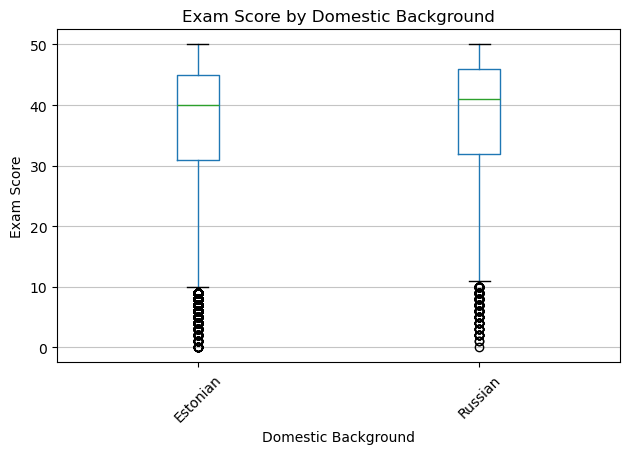

In [250]:
# Plot exam score for estonian and russian speakers as box plot
plt.figure(figsize=(10, 6))
all_data.boxplot(column='exam_score', by='domestic_background', grid=False)
plt.title('Exam Score by Domestic Background')
plt.suptitle('')
plt.xlabel('Domestic Background')
plt.ylabel('Exam Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

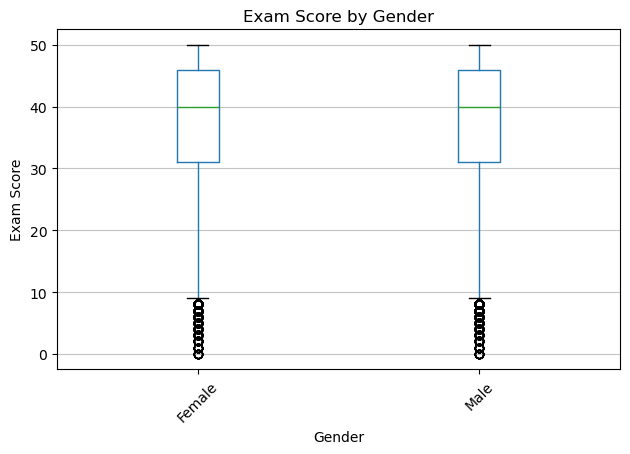

In [249]:
# Plot exam score for males and females as box plot
plt.figure(figsize=(10, 6))
all_data.boxplot(column='exam_score', by='gender', grid=False)
plt.title('Exam Score by Gender')
plt.suptitle('')
plt.xlabel('Gender')
plt.ylabel('Exam Score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()